# Modeling language with Bigrams

The idea is to understand and experiment with the basics of deep neural networs and language modeling using the paper "[A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)" as a base to work off of while using the [Wikitext 2 Raw](https://wikitext.smerity.com/wikitext-2-raw-v1.zip) dataset. Core concepts I wish to explore here:
- Mathematic formalization of the problem of language modeling to arrive at an optimization problem.
- The effects of initialization model parameters and training
- The training loop itself, overfitting and some techniques to prevent it


## Rationale

We have a text corpus $T$ of length $n$ characters, from this corpus we derive a dataset $X$ composed of all contiguous bigrams $[x_{i}, x_{i+1}]$ where $i \in 1,\dots,n-1$ (therefore $|X| = n-1$) and $x_{i} \in V$, where $V$ is the set of all characters in $T$ and we say that $|V|=m$. For any character $x_{i}$ the corpus $T$ encodes an underlying, true probability distribution for $x_{i+1}$ :
$$
P(x_{i+1}|x_{i})
$$
Our objective is to approximate that distribution as best we can by using a model composed of parameters $\Theta$ learned from our dataset $X$. The model will use character $x_{i}$ to predict $x_{i+1}$ ideally we would get:
$$
P(x_{i+1}|x_{i}) \approx P(x_{i+1}|x_{i}, \Theta)\in \mathbb{R}^{m}
$$
More practically, we can say that our model is actually a function $f_{\Theta}$ (parameterized by $\Theta$) where:
$$
\text{softmax}(f_{\Theta}(x_{i})) = P(x_{i+1}|x_{i},\Theta)
$$
Where softmax is used to turn our final $m$ logits into a valid probability distribution.

Now, this is an optimization problem. To be precise, we want to minimize the difference between the real distribution and the distribution we're estimating with out model $f_{\Theta}$. For this, we can pull from the idea of cross-entropy which is the measure that we need:
$$
H(p,q)=-\sum p(x)\log q(x)
$$
Applying it to our problem we would get a specific number for the cross-entropy between the relevant distribution this will be our loss and it will be what we want to minimize:
$$
\mathcal{L} = - \sum_{i=1}^{n-1} P(x_{i+1}|x_{i})\log P(x_{i+1}|x_{i},\Theta)
$$
Obviously, we don't have $P(x_{i+1}|x_{i})$, if we did then problem solved we could just use that, instead all we have is our dataset $X$ which tells us a lot about the real distribution for any one *specific* example.

We have all possible bigrams, therefore for any character $x_{i}$ we know what $x_{x+1}$ actually is, therefore the real distribution $P(x|x_{i})$ has a spike of probability $1$ when $x=x_{i+1}$ and a total of $0$ probability mass when $x=c$, c being any other character other than $x_{i+1}$. In formal terms:
$$
P(x|x_{i}) = \begin{cases}
1  &  \text{if} &  x=x_{i+1} \\
0 & \text{otherwise}
\end{cases}
$$
Since we're conditioning our model probability distribution on predicting $x_{i+1}$ we can say that $P(x_{i+1}|x_{i})=1$ and therefore the loss we have to minimize is:
$$
\mathcal{L} = - \sum_{i=1}^{n-1} \log P(x_{i+1}|x_{i},\Theta)
$$
In practice and mostly for computational reasons we instead calculate the loss over mini batches $B$ where $B \subset X$ (a random selection of training examples), therefore the loss we will actually use is:
$$
\mathcal{L} = -\frac{1}{|B|} \sum_{i \in B} \log (\text{softmax} (f_{\Theta}(x_{i}) )_{y_{i}})
$$
Minimizing this loss amounts to maximizing the probability of seeing the index $y_{i}$ (correct next character according to our data) when out model takes in the character $x_{i}$

### Extracting the data from the corpus

In [2]:
def read_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read()

train_raw = "./wikitext-2-raw/wiki.train.txt"
val_raw = "./wikitext-2-raw/wiki.val.txt"
test_raw = "./wikitext-2-raw/wiki.test.txt"

train_text = read_file(train_raw)

chars = sorted(list(set(train_text)))
vocab_size = len(chars)

# Create our character mappings
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Create bigrams as simple tuples of indices
bigrams = []
for i in range(len(train_text) - 1):
    input_char = train_text[i]
    target_char = train_text[i + 1]
    bigrams.append([char_to_idx[input_char], char_to_idx[target_char]])

# Let's look at what we've created
print(f"Vocabulary size: {vocab_size}")
print(f"\nFirst 10 characters in vocabulary:")
print(chars[:10])

print(f"\nFirst 5 bigrams as character pairs:")
for i in range(5):
    in_idx, out_idx = bigrams[i]
    print(f"'{idx_to_char[in_idx]}' -> '{idx_to_char[out_idx]}'")

print(f"\nTotal number of bigrams: {len(bigrams)}")

# Optional: let's also see the distribution of characters
from collections import Counter
char_counts = Counter(train_text)
print("\nMost common characters:")
for char, count in char_counts.most_common(10):
    if char.isspace():
        char_display = '<space>'
    elif char == '\n':
        char_display = '<newline>'
    else:
        char_display = char
    print(f"'{char_display}': {count}")

Vocabulary size: 1013

First 10 characters in vocabulary:
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(']

First 5 bigrams as character pairs:
' ' -> '
'
'
' -> ' '
' ' -> '='
'=' -> ' '
' ' -> 'V'

Total number of bigrams: 10918891

Most common characters:
'<space>': 2088677
'e': 990626
't': 690297
'a': 685507
'n': 593094
'i': 588695
'o': 585162
'r': 533179
's': 514154
'h': 387532


In [5]:
import torch

# Creating the dataset
data = torch.tensor(bigrams)

X, Y = data[:, 0], data[:, 1]

X.shape, Y.shape

(torch.Size([10918891]), torch.Size([10918891]))

## On initialization methods

### The core problem

It's all about the vanishing/exploding gradients problem. If the network parameters are not initialized correctly we *will* crash head first into increasing/vanishing variance (and therefore gradients) as we stack more and more layers. This applies both the forwards and backwards pass.

In a feed-forward network layers compute:
$$
\mathbf{z}^{(\ell)} = W^{(\ell)}\mathbf{a}^{(\ell-1)} +b^{(\ell)}, \quad \mathbf{a}^{(\ell)}=\phi(\mathbf{z}^{(\ell)})
$$
Where $\phi$ is our non linearity (ReLU, Sigmoid) and $\mathbf{a}^{(\ell-1)}$ are the previous layer's activations. If we treat $W^{(\ell)}$ and $\mathbf{a}^{(\ell-1)}$ as linearly independent random variables with 0 mean (which is how they are initialized), then:
$$
\text{Var}(z_{i}^{(\ell)})=\sum_{j=1}^{n_{\ell-1}}\text{Var}(W_{ij}^{(\ell)}a_{j}^{(\ell-1)}) = n_{\ell-1} \text{Var}(W^{(\ell)})\text{Var}(a^{(\ell-1)})
$$
Which means that the variance of this new layer's pre-activations is going to be scaled according to the number of neurons in the previous layers, $n_{(\ell-1)}$ which is not good in either direction. Either the variance explodes and training becomes unstable due to exploding gradients ($\text{Var}(W) \gg \frac{1}{n}$) or it vanishes towards zero and the network ends up learning nothing as the error signals follow suit ($\text{Var}(W)\ll \frac{1}{n}$).  

To address this, and knowing we can control how we initialize our parameters $W$, we must aim for $\text{Var}(W^{(\ell)})$ to be as close as it can be to $\frac{1}{n_{(\ell-1)}}$ as to maintain $\text{Var}(z^{(\ell)})$ stable through training.  



### Testing the theory on a 100 layer MLP

I will train three 100 layer MLPs, the difference will be in their parameter initialization: 

- Initialized with $\mathcal{N}(0,1)$
- Initialized with $\mathcal{U}(-1,1)$
- Initializes with $\mathcal{U}(-\sqrt{ k }, \sqrt{ k }), \quad k=\sqrt{ \frac{6}{n_{\text{in}}+n_{\text{out}}} }$, Glorot/Bengio as we'll be using `tanh`

The model will simply be an embedding layer followed by 100 fully connected layers, all of dimension $n=64$

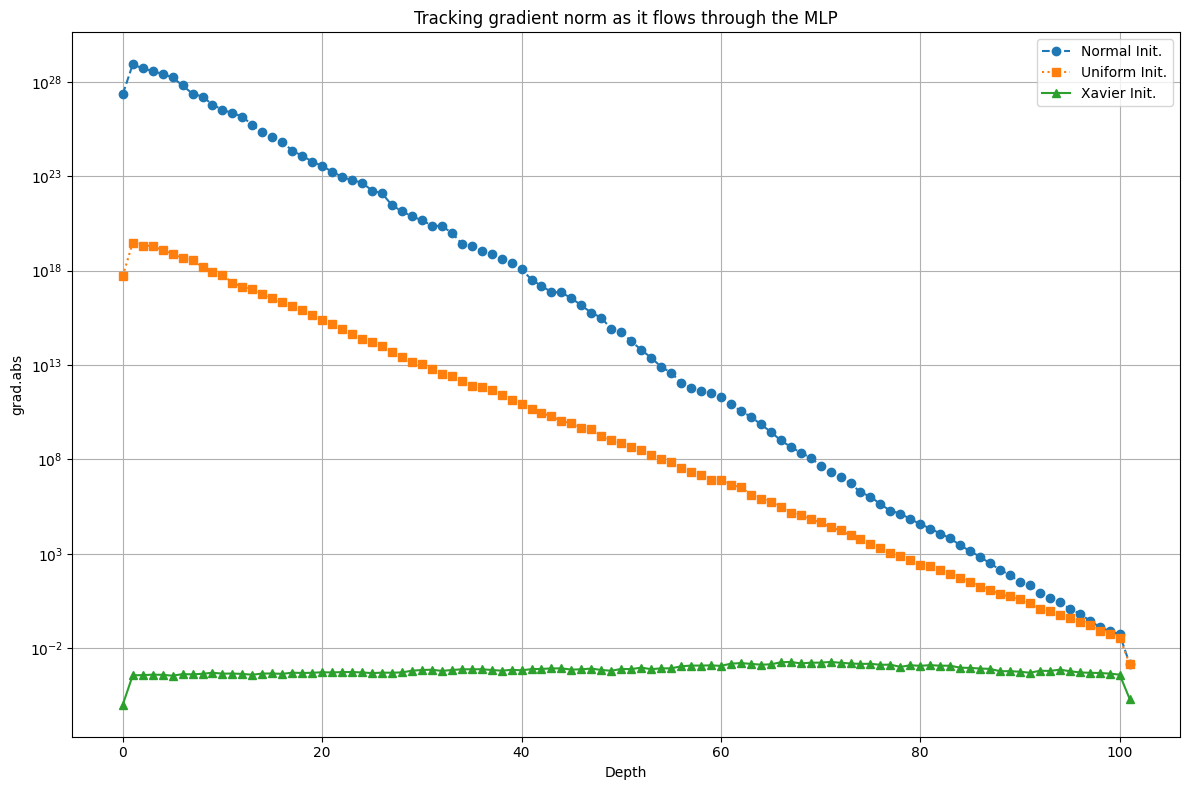

In [38]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

vocab_size = len(chars)  
model_dim = 64
model_depth = 100

def initialize_normal_model():
    embed = torch.randn(vocab_size, model_dim)  # N(0,1)
    hidden = torch.randn(model_depth, model_dim, model_dim)
    out = torch.randn(model_dim, vocab_size)

    return embed, hidden, out


def initialize_uniform_model():
    embed = torch.Tensor(vocab_size, model_dim).uniform_(-1, 1)
    hidden = torch.Tensor(model_depth, model_dim, model_dim).uniform_(-1, 1)
    out = torch.Tensor(model_dim, vocab_size).uniform_(-1, 1)

    return embed, hidden, out

def initialize_xavier_model():
    k = np.sqrt(6.0 / (model_dim + model_dim)) 
    
    embed = torch.Tensor(vocab_size, model_dim).uniform_(-k, k)
    hidden = torch.Tensor(model_depth, model_dim, model_dim).uniform_(-k, k)
    out = torch.Tensor(model_dim, vocab_size).uniform_(-k, k)

    return embed, hidden, out

def analyze_activation_statistics(init_method, X_batch, Y_batch):
    embed, hidden, out = init_method()

    params = [embed, hidden, out]
    for p in params:
        p.requires_grad_(True)

        if p.grad is not None:
            p.grad.zero_()

    # Forward pass
    X_embed = embed[X_batch]  
    
    hidden_act = torch.tanh(X_embed @ hidden[0]) 

    for layer in range(1, hidden.shape[0]):
        hidden_act = torch.tanh(hidden_act @ hidden[layer])

    out_logits = hidden_act @ out

    probs = F.softmax(out_logits, dim=-1)
    correct_logprobs = torch.log(probs[torch.arange(batch_size), Y_batch])
    loss = -correct_logprobs.mean()

    loss.backward()

    # Collecting the gradients
    grad_stats = [] 

    grad_stats.append(embed.grad.abs().mean().item())

    for layer in range(hidden.shape[0]):
        layer_grad = hidden.grad[layer] # Get the gradient for the k-th hidden matrix
        grad_stats.append(layer_grad.abs().mean().item())

    grad_stats.append(out.grad.abs().mean().item()) 

    return grad_stats

batch_size = 32
batch_idx = torch.randint(0, len(X), (batch_size,))
X_batch, Y_batch = X[batch_idx], Y[batch_idx]

normal_stats = analyze_activation_statistics(initialize_normal_model, X_batch, Y_batch)
uniform_stats = analyze_activation_statistics(initialize_uniform_model, X_batch, Y_batch)
xavier_stats = analyze_activation_statistics(initialize_xavier_model, X_batch, Y_batch)

plt.figure(figsize=(12, 8))
plt.plot(normal_stats, label="Normal Init.", marker='o', linestyle='--')
plt.plot(uniform_stats, label="Uniform Init.", marker='s', linestyle=':')
plt.plot(xavier_stats, label="Xavier Init.", marker='^', linestyle='-')
plt.yscale('log')
plt.xlabel('Depth')
plt.ylabel('grad.abs')
plt.title('Tracking gradient norm as it flows through the MLP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()